# **Dependancies**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/btc_data')

In [3]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


# **Loading Data**

In [4]:
import pandas as pd

# Đường dẫn đến file btc_data.csv
file_path = '/content/drive/My Drive/Colab Notebooks/btc_data/BTC_Data_2014-2022.csv'

# Đọc file CSV
data = pd.read_csv(file_path)


# Hiển thị 10 dòng đầu tiên
data.head(10)


,Date,priceUSD,size,sentbyaddress,transactions,mining_profitability,sentinusd,transactionfees,median_transaction_fee,confirmationtime,marketcap,transactionvalue,mediantransactionvalue,tweets,google_trends,fee_to_reward,activeaddresses,top100cap
0,2014/04/09,447.110,243742.0,122401,64992,38.678,239212041.0,0.1390,0.0447,8.944,5587996110,4115.0,100.420,8193,11.193,0.502,179274,19.211
1,2014/04/10,407.703,254334.0,124298,67872,31.917,310367120.0,0.0864,0.0408,9.290,5020359905,4876.0,120.946,15039,13.854,0.371,182996,19.166
2,2014/04/11,403.328,223656.0,117926,65563,36.814,292756343.0,0.0858,0.0403,8.521,5068919648,4819.0,108.481,14907,12.997,0.330,169622,19.141
3,2014/04/12,425.310,169964.0,87828,47579,34.498,157264741.0,0.0811,0.0425,8.944,5329088351,3574.0,84.408,7582,9.229,0.226,132283,19.145
4,2014/04/13,415.876,162260.0,94828,50981,34.141,154756367.0,0.0840,0.0416,7.701,5150414718,3332.0,69.681,10674,10.385,0.221,172708,19.131
5,2014/04/14,445.898,216048.0,127969,70026,37.973,253143718.0,0.0977,0.0446,7.461,5628122040,3990.0,115.249,13266,10.754,0.318,183291,19.146
6,2014/04/15,487.666,241539.0,123107,72627,38.650,293892234.0,0.1110,0.0488,7.912,6170470953,4479.0,123.089,14835,11.053,0.362,199054,19.124
7,2014/04/16,517.354,270984.0,114312,68435,40.201,389249585.0,0.1080,0.0517,9.057,6496569317,6046.0,129.799,15790,12.189,0.359,185075,19.146
8,2014/04/17,505.461,223631.0,102596,65021,40.706,385378002.0,0.1170,0.0505,8.521,6281237538,6384.0,102.416,15215,11.471,0.355,157751,19.092
9,2014/04/18,485.296,205478.0,100633,56836,35.818,360602878.0,0.1040,0.0485,9.000,5972292967,6461.0,107.713,14028,9.946,0.304,149452,19.054


# **Model Architecture + Training**

In [ ]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import ModelCheckpoint
from itertools import product
from keras_tuner import HyperModel, RandomSearch

# Chuẩn bị dữ liệu

data['Date'] = pd.to_datetime(data['Date'])
X = data.drop(columns=['priceUSD', 'Date'])
y = data['priceUSD']

# Chia dữ liệu thành tập huấn luyện và kiểm tra
split_index = int(len(X) * 0.9)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

In [ ]:

# Tối ưu hóa tham số cho SARIMAX
def optimize_sarimax(y_train, X_train):
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None

    # Các giá trị cho p, d, q, P, D, Q, s
    p_values = [0, 1, 2]
    d_values = [0, 1, 2]
    q_values = [0, 1, 2]
    seasonal_periods = [12]  # Ví dụ cho dữ liệu theo tháng (s = 12)

    # Tạo danh sách các giá trị kết hợp của tham số
    param_grid = list(product(p_values, d_values, q_values, p_values, d_values, q_values, seasonal_periods))

    for order in param_grid:
        try:
            sarimax_model = SARIMAX(y_train, exog=X_train, order=(order[0], order[1], order[2]),
                                    seasonal_order=(order[3], order[4], order[5], order[6]))
            result = sarimax_model.fit(disp=False)
            aic = result.aic
            if aic < best_aic:
                best_aic = aic
                best_order = (order[0], order[1], order[2])
                best_seasonal_order = (order[3], order[4], order[5], order[6])
        except:
            continue

    print(f"Best SARIMAX order: {best_order}")
    print(f"Best SARIMAX seasonal order: {best_seasonal_order}")
    return best_order, best_seasonal_order

# Tối ưu hóa SARIMAX
best_order, best_seasonal_order = optimize_sarimax(y_train_scaled, X_train)

# Huấn luyện mô hình SARIMAX với tham số tối ưu
sarimax_model = SARIMAX(y_train_scaled, exog=X_train, order=best_order, seasonal_order=best_seasonal_order)
sarimax_result = sarimax_model.fit(disp=False)

# Lưu mô hình SARIMAX
save_dir = '/content/drive/My Drive/Colab Notebooks/btc_data/hybrid_model_SARIMAX-LSTM_Tham_So'
os.makedirs(save_dir, exist_ok=True)
sarimax_model_path = os.path.join(save_dir, 'sarimax_model.pkl')
with open(sarimax_model_path, 'wb') as f:
    pickle.dump(sarimax_result, f)
print(f"SARIMAX model saved at: {sarimax_model_path}")


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Best SARIMAX order: (0, 1, 1)
Best SARIMAX seasonal order: (0, 0, 0, 12)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX model saved at: /content/drive/My Drive/Colab Notebooks/btc_data/hybrid_model_Tham_So/sarimax_model.pkl


In [5]:
!pip install -U keras-tuner


In [6]:
import os
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, LayerNormalization, Dropout, Input
from keras import Model
from keras.callbacks import EarlyStopping
from keras_tuner import HyperModel, RandomSearch
from keras.layers import MultiHeadAttention
import tensorflow as tf

# **1. Tải dữ liệu**
X = data.drop(columns=['priceUSD', 'Date'])
y = data['priceUSD']

# **2. Chia dữ liệu**
split_index = int(len(X) * 0.9)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# **3. Chuẩn hóa dữ liệu**
scaler = MinMaxScaler()
y_train = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler.transform(y_test.values.reshape(-1, 1))

# **4. Tải mô hình SARIMAX**
save_dir = '/content/drive/My Drive/Colab Notebooks/btc_data/hybrid_model_SARIMAX-LSTM_Tham_So'
sarimax_model_path = os.path.join(save_dir, 'sarimax_model.pkl')
with open(sarimax_model_path, 'rb') as f:
    sarimax_result = pickle.load(f)

# **5. Dự báo SARIMAX**
sarimax_pred_train_scaled = sarimax_result.fittedvalues
sarimax_pred_test_scaled = sarimax_result.predict(
    start=len(y_train),
    end=len(y_train) + len(y_test) - 1,
    exog=X_test
)

# **6. Tính residuals**
residual_train = y_train - sarimax_pred_train_scaled.values.reshape(-1, 1)
residual_test = y_test - sarimax_pred_test_scaled.values.reshape(-1, 1)

# **7. Xây dựng lớp HyperModel**
class PathformerHyperModel(HyperModel):
    def build(self, hp):
        inputs = Input(shape=(1, 1))
        x = Dense(hp.Int('units', 64, 256, step=64), activation='relu')(inputs)
        x = LayerNormalization()(x)
        x = Dropout(hp.Float('dropout_rate', 0.1, 0.5, step=0.1))(x)
        for _ in range(hp.Int('num_transformer_blocks', 1, 3)):
            x = self.transformer_block(x, hp)
        output = Dense(1)(x)
        model = Model(inputs=inputs, outputs=output)
        model.compile(optimizer='adam', loss='mse')
        return model

    def transformer_block(self, x, hp):
        num_heads = hp.Choice('num_heads', [2, 3, 4])
        key_dim = hp.Choice('key_dim', [32, 48])
        ff_units = hp.Choice('units_ff', [128, 256])
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
        attn_output = Dropout(0.1)(attn_output)
        x = LayerNormalization()(x + attn_output)
        ff = Dense(ff_units, activation='relu')(x)
        ff = Dense(x.shape[-1])(ff)
        ff = Dropout(0.1)(ff)
        x = LayerNormalization()(x + ff)
        return x

# **8. Tìm kiếm tham số tốt nhất với Hyperparameter Tuning**
pathformer_hypermodel = PathformerHyperModel()
tuner = RandomSearch(
    pathformer_hypermodel,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='pathformer_optimization'
)

residual_train_reshaped = residual_train.reshape(residual_train.shape[0], 1, 1)
residual_test_reshaped = residual_test.reshape(residual_test.shape[0], 1, 1)

early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

tuner.search(
    residual_train_reshaped, residual_train,
    epochs=200, batch_size=32,
    validation_data=(residual_test_reshaped, residual_test),
    callbacks=[early_stopping]
)

# In tất cả các tham số của các mô hình đã chạy
print("Các tham số của tất cả các mô hình đã chạy:")
for trial in tuner.oracle.trials.values():
    print(f"Trial ID: {trial.trial_id}")
    print(f"Parameters: {trial.hyperparameters.values}")
    print(f"Score: {trial.score}\n")


# **9. Huấn luyện và đánh giá mô hình Pathformer**
best_pathformer_model = tuner.get_best_models(num_models=1)[0]

pathformer_pred_train = best_pathformer_model.predict(residual_train_reshaped).reshape(-1, 1)
pathformer_pred_test = best_pathformer_model.predict(residual_test_reshaped).reshape(-1, 1)

combined_pred_train = sarimax_pred_train_scaled.values.reshape(-1, 1) + pathformer_pred_train
combined_pred_test = sarimax_pred_test_scaled.values.reshape(-1, 1) + pathformer_pred_test

# **10. Phục hồi giá trị gốc**
y_train_original = scaler.inverse_transform(y_train)
y_test_original = scaler.inverse_transform(y_test)
combined_pred_train_original = scaler.inverse_transform(combined_pred_train)
combined_pred_test_original = scaler.inverse_transform(combined_pred_test)

# **11. Đánh giá mô hình**
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, r2, mse, mape

mae, rmse, r2, mse, mape = evaluate_model(y_test_original, combined_pred_test_original)

print(f'Test MAE: {mae}')
print(f'Test RMSE: {rmse}')
print(f'Test R2: {r2}')
print(f'Test MSE: {mse}')
print(f'Test MAPE: {mape}%')

# **12. Lưu mô hình tốt nhất**
pathformer_model_path = os.path.join(save_dir, 'best_SARIMAX_pathformer_model.keras')
best_pathformer_model.save(pathformer_model_path)
print(f"Pathformer model saved to: {pathformer_model_path}")


Trial 10 Complete [00h 02m 06s]
val_loss: 5.675623171441657e-08

Best val_loss So Far: 5.675623171441657e-08
Total elapsed time: 00h 53m 35s
Các tham số của tất cả các mô hình đã chạy:
Trial ID: 00
Parameters: {'units': 64, 'dropout_rate': 0.2, 'num_transformer_blocks': 3, 'num_heads': 3, 'key_dim': 32, 'units_ff': 128}
Score: 3.7560319015028654e-06

Trial ID: 01
Parameters: {'units': 64, 'dropout_rate': 0.5, 'num_transformer_blocks': 1, 'num_heads': 4, 'key_dim': 32, 'units_ff': 128}
Score: 2.5375180712217116e-07

Trial ID: 02
Parameters: {'units': 128, 'dropout_rate': 0.1, 'num_transformer_blocks': 1, 'num_heads': 4, 'key_dim': 32, 'units_ff': 128}
Score: 3.89004026146722e-06

Trial ID: 03
Parameters: {'units': 256, 'dropout_rate': 0.30000000000000004, 'num_transformer_blocks': 1, 'num_heads': 2, 'key_dim': 48, 'units_ff': 256}
Score: 4.10408529205597e-06

Trial ID: 04
Parameters: {'units': 64, 'dropout_rate': 0.5, 'num_transformer_blocks': 2, 'num_heads': 2, 'key_dim': 48, 'units_ff

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Test MAE: 15.234088514887095
Test RMSE: 16.045035059361535
Test R2: 0.9999972390407864
Test MSE: 257.4431500561408
Test MAPE: 0.057132755927418365%
Pathformer model saved to: /content/drive/My Drive/Colab Notebooks/btc_data/hybrid_model_SARIMAX-LSTM_Tham_So/best_SARIMAX_pathformer_model.keras


In [8]:
import matplotlib.pyplot as plt

# Hiển thị kết quả dự đoán và giá trị thực tế
results = pd.DataFrame({
    'Actual': y_test_original.flatten(),
    'Predicted': combined_pred_test_original.flatten()
})
print(results.head(10))

# Lưu kết quả vào file CSV
results_path = os.path.join(save_dir, 'result_predictions_SARIMAX_pathformer_model.csv')
results.to_csv(results_path, index=False)
print(f"Predictions saved to: {results_path}")

    Actual     Predicted
0  43854.0  43875.384274
1  43922.0  43943.118499
2  44331.0  44352.468932
3  43185.0  43205.708781
4  42333.0  42353.268004
5  42336.0  42356.193346
6  42232.0  42252.251709
7  43867.0  43888.434587
8  43998.0  44019.589191
9  42666.0  42686.780830
Predictions saved to: /content/drive/My Drive/Colab Notebooks/btc_data/hybrid_model_SARIMAX-LSTM_Tham_So/result_predictions_SARIMAX_pathformer_model.csv


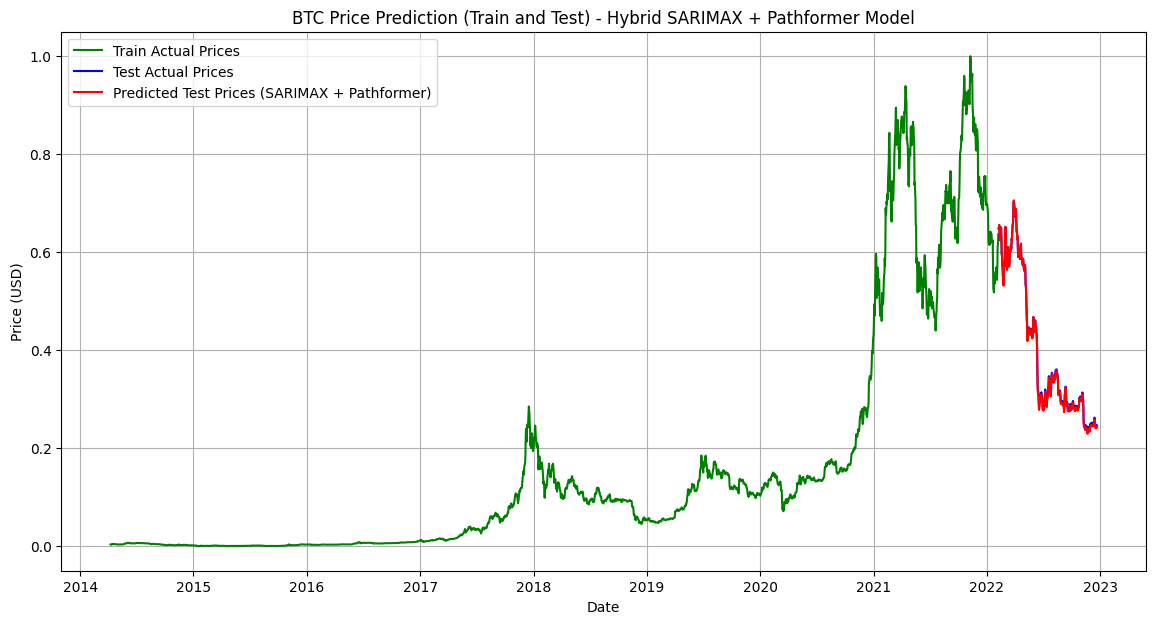

In [32]:
# Đảm bảo rằng combined_pred_test_original có số lượng phần tử khớp với dữ liệu kiểm tra
combined_pred_test_original_resized = combined_pred_test_original[:len(data.iloc[split_index:])]

# **Vẽ đồ thị toàn bộ dữ liệu (Train, Test và Dự đoán)**
plt.figure(figsize=(14, 7))

# Plot dữ liệu train
plt.plot(data.iloc[:split_index]['Date'], y_train_original.flatten(), label='Train Actual Prices', color='green')

# Plot dữ liệu test
plt.plot(data.iloc[split_index:]['Date'], y_test_original.flatten(), label='Test Actual Prices', color='blue')

# Plot dự đoán tập test (dự đoán kết hợp từ SARIMAX và Pathformer)
plt.plot(data.iloc[split_index:]['Date'], combined_pred_test_original_resized.flatten(), label='Predicted Test Prices (SARIMAX + Pathformer)', color='red')

# Thông tin đồ thị
plt.title('BTC Price Prediction (Train and Test) - Hybrid SARIMAX + Pathformer Model')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)

# Hiển thị đồ thị
plt.show()


Shape of combined_pred_test_original: (318, 1)
Shape of test_dates: (318,)


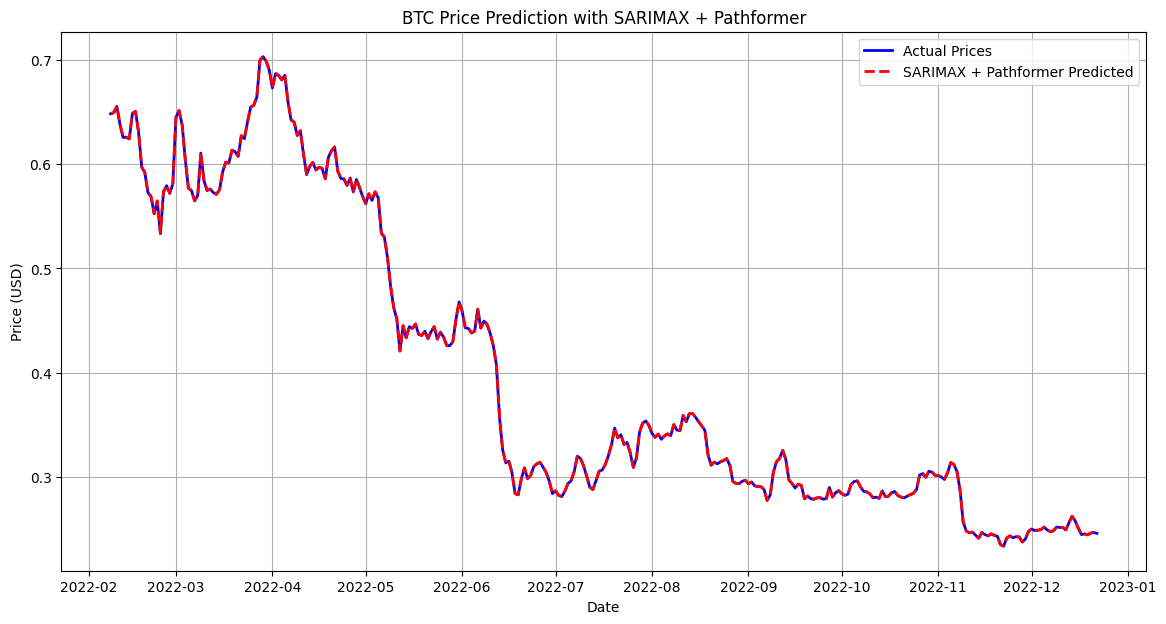

In [47]:
# Ensure that combined_pred_test is correctly aligned with test_dates
combined_pred_test_original = scaler.inverse_transform(combined_pred_test)  # Ensure this has same shape as y_test_original

# Check the shape of combined_pred_test_original and test_dates
print(f"Shape of combined_pred_test_original: {combined_pred_test_original.shape}")
print(f"Shape of test_dates: {test_dates.shape}")

# Ensure both arrays have the same length
if len(combined_pred_test_original) == len(test_dates):
    plt.figure(figsize=(14, 7))

    # Dữ liệu thực tế
    plt.plot(test_dates, y_test_original.flatten(), label='Actual Prices', color='blue', linestyle='-', linewidth=2)

    # Dự đoán kết hợp SARIMAX + LSTM
    plt.plot(test_dates, combined_pred_test_original.flatten(), label='SARIMAX + Pathformer Predicted', color='red', linestyle='--', linewidth=2)

    # Thông tin đồ thị
    plt.title('BTC Price Prediction with SARIMAX + Pathformer')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid()
    plt.show()

else:
    print(f"Error: Length mismatch between predictions ({len(combined_pred_test_original)}) and test dates ({len(test_dates)})")
